In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import optuna
import wandb
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

wandb.login(key="017a8a1cf1968e847ba05f92a8935af78befe33f")

cuda


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rabeaotman (rabeaotman-tel-aviv-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib  # לשמירת ה-LabelEncoder (אופציונלי)

# --- טעינת הדאטה ---
df = pd.read_csv("/kaggle/input/eda2-bertweet/bertweet-eda2.csv" , encoding ='latin1')

# שינוי שם עמודת הטקסט
df = df.rename(columns={'clean_eda_2': 'Tweet'})

# קידוד התוויות ממחרוזות למספרים
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Sentiment'])

# שמירת המיפוי לשימוש עתידי (אופציונלי)
joblib.dump(label_encoder, "label_encoder.pkl")

# הצגת המיפוי
for i, label in enumerate(label_encoder.classes_):
    print(f"{i} → {label}")

# --- חלוקה ל-Train / Eval /  ---
train_df, eval_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label']
)


# שמירה של רק העמודות הדרושות למודל
train_df = train_df[['Tweet', 'label']]
eval_df = eval_df[['Tweet', 'label']]


# שמירת קבצים
train_df.to_csv("train_data.csv", index=False)
eval_df.to_csv("eval_data.csv", index=False)

print(train_df['Tweet'].iloc[80])

0 → Extremely Negative
1 → Extremely Positive
2 → Negative
3 → Neutral
4 → Positive
#covid 19 has hit all over the world and people are stocking stuffs like hell. but country like usa, the grocery store run out the stuffs whereas in nepal, the merchants are hiding stuffs making fake shortage so that they can make money of the pandemic. what a pitty shame!! URL


In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# ===== 1) Base architecture =====
model_name = "vinai/bertweet-large"
num_labels = 5
CKPT_PATH = "/kaggle/input/best_bertweet-exc4/pytorch/default/1/best_model_trial_2_bertweet2.pt"  # <-- your file

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=num_labels
).to(device)

# ===== 2) Load checkpoint =====
ckpt = torch.load(CKPT_PATH, map_location=device)

# support both formats: pure state_dict OR {"model_state_dict": ...}
state_dict = ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt

# ---- strip ONLY the "module." prefix when present (from DataParallel) ----
clean_state = {}
for k, v in state_dict.items():
    if k.startswith("module."):
        clean_state[k[len("module."):]] = v
    else:
        clean_state[k] = v

# ---- (optional) drop classifier head keys if shapes don't match ----
model_state = model.state_dict()
filtered = {}
dropped = []
for k, v in clean_state.items():
    if k in model_state:
        if model_state[k].shape == v.shape:
            filtered[k] = v
        else:
            # if the saved head has a different shape (e.g., different num_labels)
            if k.startswith(("classifier.", "score.", "classification_head.")):
                dropped.append(k)
            else:
                # keep non-head mismatches out to avoid errors
                # (rare unless architecture changed)
                pass
    else:
        # keys that don't exist in current model_state will be treated as 'unexpected'
        # we simply don't include them in filtered
        pass

missing, unexpected = model.load_state_dict(filtered, strict=False)

print(f"Loaded checkpoint: {CKPT_PATH}")
print(f"Dropped classifier keys due to shape mismatch: {len(dropped)}")
if dropped:
    for dk in dropped[:8]:
        print("  -", dk)
    if len(dropped) > 8:
        print(f"  ... and {len(dropped)-8} more")

print("Missing keys:", missing)
print("Unexpected keys:", unexpected)


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

2025-08-19 16:24:19.122214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755620659.284421      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755620659.334068      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Loaded checkpoint: /kaggle/input/best_bertweet-exc4/pytorch/default/1/best_model_trial_2_bertweet2.pt
Dropped classifier keys due to shape mismatch: 0
Missing keys: []
Unexpected keys: []


In [4]:
class TweetDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.texts = dataframe['Tweet'].tolist()
        self.labels = dataframe['label'].tolist() 
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=96,  
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
from torch import nn

# חישוב משקלי תוויות לפי הופעה בפועל — על ה-TRAIN בלבד
train_labels = train_df['label'].values
classes = np.unique(train_labels)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_labels
)

# הפיכה לטנסור לשימוש בתוך CrossEntropyLoss
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float, device=device)

# פונקציית הפסד עם משקלים
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# אופציונלי: להדפיס כדי לדעת מה קיבלת
print("Classes:", classes)
print("Class weights:", class_weights)


Classes: [0 1 2 3 4]
Class weights: [1.49396985 1.23687595 0.82823857 1.08395757 0.71827367]


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/3273585051.py:124: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Epoch 1/15:   0%|          | 0/511 [00:00<?, ?it/s]

/tmp/ipykernel_36/3273585051.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_36/3273585051.py:139: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 2/15:   0%|          | 0/511 [00:00<?, ?it/s]

/tmp/ipykernel_36/3273585051.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_36/3273585051.py:139: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 3/15:   0%|          | 0/511 [00:00<?, ?it/s]

/tmp/ipykernel_36/3273585051.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_36/3273585051.py:139: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 4/15:   0%|          | 0/511 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eed3d433920><function _MultiProcessingDataLoaderIter.__del__ at 0x7eed3d433920>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
assert self._par

Epoch 5/15:   0%|          | 0/511 [00:00<?, ?it/s]

/tmp/ipykernel_36/3273585051.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_36/3273585051.py:139: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 6/15:   0%|          | 0/511 [00:00<?, ?it/s]

/tmp/ipykernel_36/3273585051.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eed3d433920>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eed3d433920>
Traceback (most recent call 

Epoch 7/15:   0%|          | 0/511 [00:00<?, ?it/s]

/tmp/ipykernel_36/3273585051.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eed3d433920>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eed3d433920>
Traceback (most recent call 

Early stopping at epoch 7 (no val_loss improvement for 2 epoch(s)).
Best val loss: 0.812838
Best checkpoint saved to: ./final_15ep_checkpoints/best_model_final_15p_ex4.pt


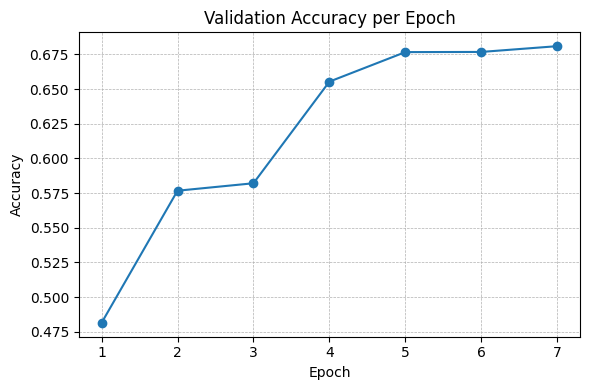

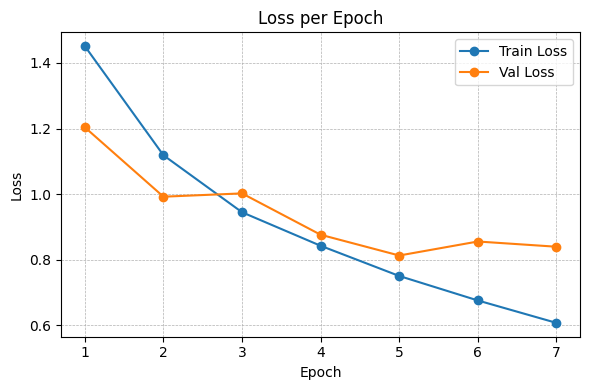

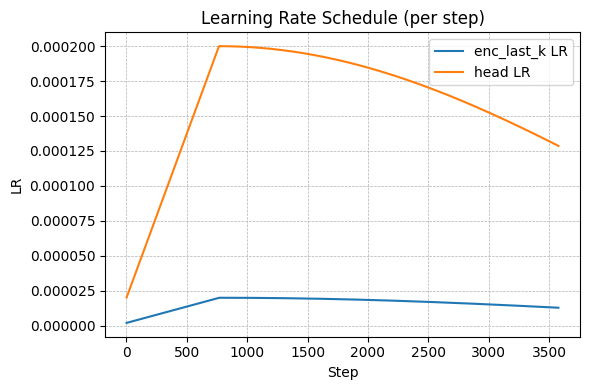

Saved figures to: /kaggle/working/val_accuracy_per_epoch.png, /kaggle/working/loss_per_epoch.png, /kaggle/working/lr_schedule.png


epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇██
train/epoch_loss,█▅▄▃▂▂▁
train/loss,███▇▇▆▆▆▅▅▆▅▅▄▄▄▄▅▄▄▄▅▅▃▃▃▂▄▂▃▂▂▂▂▂▂▂▁▂▃
train/lr_enc,▁▁▂▃▃▄▅▇▇█████████████▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅
train/lr_head,▁▁▂▂▃▄▅▇▇███████████▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅
val/acc,▁▄▅▇███
val/f1_macro,▁▅▄▇███
val/loss,█▄▄▂▁▂▁
epoch,7
step,3550


In [6]:
# =========================
# 0) Imports & basic config
# =========================
import os
import math
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm
import wandb

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

history = {"epoch": [], "train_loss": [], "val_loss": [], "val_acc": [], "val_f1_macro": []}
# (optional) track LR across steps to visualize the scheduler curve
lr_history_enc, lr_history_head = [], []

# ========= W&B toggle =========
USE_WANDB = True
WANDB_PROJECT = "Finetune-bertweet-ex4-take-2"
RUN_NAME = "final_15p_ex4"

# ======================================
# 1) Best hyperparameters (from Optuna)
# ======================================
best_params = {
    'learning_rate': 0.00013216020928849163,  # kept for reference; we override with per-group LRs below
    'weight_decay': 8.692956783751181e-06,    # will override to 0.01
    'patience': 2,
    'batch_size': 64,
    'num_layers': 3
}
EPOCHS = 15
GRAD_CLIP_NORM = 1.0
EVAL_EVERY_EPOCH = True
SAVE_DIR = "./final_15ep_checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

# ======================================
# 2) Tokenizer, datasets, dataloaders
# ======================================
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large", use_fast=False)

# Assumes you already have TweetDataset(train_df, tokenizer) and TweetDataset(eval_df, tokenizer)
train_dataset = TweetDataset(train_df, tokenizer)
val_dataset   = TweetDataset(eval_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=best_params["batch_size"], shuffle=False, num_workers=2)

# ======================================
# 3) Model + freezing policy
# ======================================
num_labels = 5  # adjust if needed
model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/bertweet-large", num_labels=num_labels
).to(device)

# Optional: slightly stronger dropout for regularization
model.config.attention_probs_dropout_prob = 0.15
model.config.hidden_dropout_prob = 0.15

# Freeze all encoder layers
for p in model.roberta.parameters():
    p.requires_grad = False

# Unfreeze the last `num_layers` encoder blocks
k = best_params["num_layers"]
for p in model.roberta.encoder.layer[-k:].parameters():
    p.requires_grad = True

# Always train the classifier head
for p in model.classifier.parameters():
    p.requires_grad = True

# ======================================
# 4) Loss, optimizer (AdamW, layer-wise LR), scheduler (warmup → cosine)
# ======================================
# Make sure class_weights_tensor exists and is on device
# class_weights_tensor = class_weights_tensor.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Parameter groups: lower LR for encoder layers, higher LR for head
enc_lastk_params = list(model.roberta.encoder.layer[-k:].parameters())
head_params      = list(model.classifier.parameters())

# Recommended LRs
lr_enc  = 2e-5       # conservative for BERT layers
lr_head = 2e-4       # classifier can be an order of magnitude higher

optimizer = AdamW(
    [
        {"params": enc_lastk_params, "lr": lr_enc,  "weight_decay": 0.01},
        {"params": head_params,      "lr": lr_head, "weight_decay": 0.01},
    ],
    betas=(0.9, 0.999),
    eps=1e-8
)

# Warmup (10% steps) -> Cosine decay over remaining steps
total_steps  = len(train_loader) * EPOCHS
warmup_steps = max(1, int(0.10 * total_steps))

warmup  = LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=warmup_steps)
cosine  = CosineAnnealingLR(optimizer, T_max=(total_steps - warmup_steps))
scheduler = SequentialLR(optimizer, schedulers=[warmup, cosine], milestones=[warmup_steps])

# Mixed precision
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

# ======================================
# 5) Helper: evaluation
# ======================================
@torch.no_grad()
def evaluate(model, data_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0
    for batch in data_loader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

        total_loss += loss.item() * input_ids.size(0)
        preds = outputs.logits.argmax(dim=1)

        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

    all_preds  = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    avg_loss   = total_loss / len(data_loader.dataset)
    acc        = accuracy_score(all_labels, all_preds)
    f1m        = f1_score(all_labels, all_preds, average="macro")
    return {"val_loss": avg_loss, "val_acc": acc, "val_f1_macro": f1m}

# ======================================
# 6) Training loop + Early Stopping
# ======================================
if USE_WANDB:
    wandb.init(
        project=WANDB_PROJECT,
        name=RUN_NAME,
        config=dict(best_params, epochs=EPOCHS, architecture="BERTweet-Large", mode="non-HF",
                    lr_enc=lr_enc, lr_head=lr_head, wd=0.01, warmup_frac=0.10)
    )
    wandb.watch(model, log="all", log_freq=200)

best_path = os.path.join(SAVE_DIR, f"best_model_{RUN_NAME}.pt")

best_val_loss = float("inf")
epochs_no_improve = 0
min_delta = 1e-4  # improvement threshold for early stopping

global_step = 0
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)

    for batch in pbar:
        optimizer.zero_grad(set_to_none=True)

        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()

        # gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)

        scaler.step(optimizer)
        scaler.update()

        scheduler.step()

        # track both param-group LRs
        lr_enc_curr  = optimizer.param_groups[0]["lr"]
        lr_head_curr = optimizer.param_groups[1]["lr"]
        lr_history_enc.append(lr_enc_curr)
        lr_history_head.append(lr_head_curr)

        running_loss += loss.item() * input_ids.size(0)

        global_step += 1
        if USE_WANDB and global_step % 50 == 0:
            wandb.log({
                "train/loss": loss.item(),
                "train/lr_enc": lr_enc_curr,
                "train/lr_head": lr_head_curr,
                "step": global_step,
                "epoch": epoch
            })

    train_loss = running_loss / len(train_loader.dataset)

    # Evaluate at epoch end
    if EVAL_EVERY_EPOCH:
        metrics = evaluate(model, val_loader, device)
        val_loss = metrics["val_loss"]
        val_acc  = metrics["val_acc"]
        val_f1m  = metrics["val_f1_macro"]

        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1_macro"].append(val_f1m)

        if USE_WANDB:
            wandb.log({
                "epoch": epoch,
                "train/epoch_loss": train_loss,
                "val/loss": val_loss,
                "val/acc": val_acc,
                "val/f1_macro": val_f1m
            })

        # ---- Early stopping on val_loss ----
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save({
                "model_state_dict": model.state_dict(),
                "best_val_loss": best_val_loss,
                "epoch": epoch,
                "params": best_params,
                "lr_enc": lr_enc,
                "lr_head": lr_head
            }, best_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= best_params["patience"]:
                print(f"Early stopping at epoch {epoch} (no val_loss improvement for {best_params['patience']} epoch(s)).")
                break

print(f"Best val loss: {best_val_loss:.6f}")
print(f"Best checkpoint saved to: {best_path}")

# ===== Plot 1: Accuracy over epochs =====
plt.figure(figsize=(6,4))
plt.plot(history["epoch"], history["val_acc"], marker="o")
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig("/kaggle/working/val_accuracy_per_epoch.png", dpi=150)
plt.show()

# ===== Plot 2: Loss over epochs (train vs val) =====
plt.figure(figsize=(6,4))
plt.plot(history["epoch"], history["train_loss"], marker="o", label="Train Loss")
plt.plot(history["epoch"], history["val_loss"],   marker="o", label="Val Loss")
plt.title("Loss per Epoch"); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig("/kaggle/working/loss_per_epoch.png", dpi=150)
plt.show()

# ===== Plot 3: Learning rates over steps (enc vs head) =====
if len(lr_history_enc) > 0:
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(lr_history_enc)+1), lr_history_enc, label="enc_last_k LR")
    plt.plot(range(1, len(lr_history_head)+1), lr_history_head, label="head LR")
    plt.title("Learning Rate Schedule (per step)")
    plt.xlabel("Step"); plt.ylabel("LR")
    plt.legend(); plt.grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.savefig("/kaggle/working/lr_schedule.png", dpi=150)
    plt.show()

print("Saved figures to:",
      "/kaggle/working/val_accuracy_per_epoch.png,",
      "/kaggle/working/loss_per_epoch.png,",
      "/kaggle/working/lr_schedule.png")

if USE_WANDB:
    wandb.finish()
